In [1]:
#Import Packages
import os
import pandas as pd
import numpy as np

#Change Working Directory
os.chdir(r'C:\Users\malva\Thesis')

#Read data file
data = pd.read_csv('Files\Samples\Bergueda_Sample.csv')
data.head()

,lat,long,elevation,slope,aspect,curv_plan,curv_prof,facc,twi,soil,lulc,response
0,4682432.5,415802.5,1662.61,28.607676,209.43265,-0.030294,0.019568,4.197969,10.272434,12.0,5.0,1.0
1,4681897.5,403107.5,1343.52,36.750950,197.29430,-0.000409,0.000365,3.113943,7.462130,7.0,6.0,1.0
2,4681822.5,419452.5,1441.22,23.992632,183.99313,0.048947,0.007482,3.021189,7.766060,12.0,5.0,1.0
3,4681792.5,419462.5,1428.08,23.833015,189.24863,0.020361,0.001992,2.977724,7.673494,12.0,5.0,1.0
4,4681782.5,414537.5,1455.97,52.255924,176.98232,0.003440,0.027422,1.698970,3.655993,9.0,8.0,1.0


In [2]:
print('Soil: ' + str(sorted(data['soil'].unique())))
print('LULC: ' + str(sorted(data['lulc'].unique())))

Soil: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 13.0]
LULC: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


In [3]:
#Reclassification

#Soil
data.soil.replace([2,6], 6, inplace = True)
data.soil.replace(8, 2, inplace = True)
data.soil.replace([3,4,5], 3, inplace = True)
data.soil.replace([1,7,13], 7, inplace = True)
data.soil.replace(9, 1, inplace = True)
data.soil.replace(10, 11, inplace = True)
data.soil.replace(11, 6, inplace = True)
data.soil.replace(12, 7, inplace = True)

#LULC
replace_dict = {6:1, 5:2, 4:3, 7:4, 8:7, 2:8, 1:9, 3:2}
data.lulc.replace(replace_dict, inplace = True)

In [4]:
print('Soil: ' + str(sorted(data['soil'].unique())))
print('LULC: ' + str(sorted(data['lulc'].unique())))

Soil: [1.0, 2.0, 3.0, 6.0, 7.0]
LULC: [1.0, 2.0, 3.0, 4.0, 7.0, 8.0]


In [5]:
#Encoding Categorical with Pandas
X = pd.get_dummies(data, columns = ['soil', 'lulc'])
X = X.drop(columns=['lat', 'long', 'elevation', 'response'])

In [6]:
#Complete missing columns

#Soil
X['soil_4.0'] = 0
X['soil_5.0'] = 0
X['soil_6.0'] = 0
X['soil_7.0'] = 0
X['soil_8.0'] = 0
X['soil_9.0'] = 0
X['soil_10.0'] = 0
X['soil_11.0'] = 0

#LULC
X['lulc_5.0'] = 0
X['lulc_6.0'] = 0
X['lulc_9.0'] = 0
X['lulc_10.0'] = 0

X.sort_index(axis=1, inplace=True)
X.columns

Index(['aspect', 'curv_plan', 'curv_prof', 'facc', 'lulc_1.0', 'lulc_10.0',
       'lulc_2.0', 'lulc_3.0', 'lulc_4.0', 'lulc_5.0', 'lulc_6.0', 'lulc_7.0',
       'lulc_8.0', 'lulc_9.0', 'slope', 'soil_1.0', 'soil_10.0', 'soil_11.0',
       'soil_2.0', 'soil_3.0', 'soil_4.0', 'soil_5.0', 'soil_6.0', 'soil_7.0',
       'soil_8.0', 'soil_9.0', 'twi'],
      dtype='object')

In [7]:
#Create inputs and outputs for the data-driven model
y = data['response'].values

In [8]:
#Import Val d'Aran Logistic Model
import pickle

pkl_filename = 'Files\Models\logreg_norain.pkl'
logreg = pickle.load(open(pkl_filename, 'rb'))

In [9]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#Logistic Regression

#Berguedà
y_pred_prob = logreg.predict_proba(X)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_prob)
auc = metrics.roc_auc_score(y, y_pred_prob)

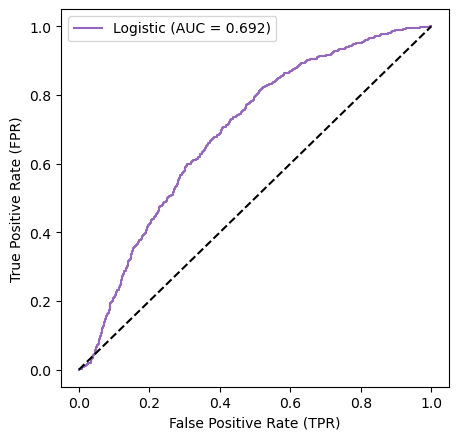

In [10]:
#Plot the ROC curve and calculate AUC
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, marker='', color='tab:purple', label='Logistic (AUC = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (TPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend()
plt.savefig(r'C:\Users\malva\Desktop\Test\berguedalogistic.png', dpi=300)
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

y_pred = logreg.predict(X)
matrix = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)
FP = matrix[0,1]
TN = matrix[0,0]
fpr = FP/(FP+TN)
fnr = 1 - recall_score(y, y_pred)
mcc = matthews_corrcoef(y, y_pred)
stats = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc, fpr, fnr, mcc)

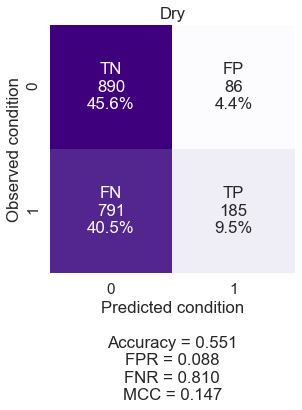

In [12]:
import seaborn as sns

sns.set(font_scale=1.4)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 6))

low_lim = np.min(matrix)
upp_lim = np.max(matrix)

#Heatmap No Rain
group_names = ['TN', 'FP','FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=False, cmap='Purples')

ax.set_title('Dry')
ax.set_ylabel('Observed condition')
ax.set_xlabel('Predicted condition' + stats)
plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\confusionlogisticbergueda.png', dpi=300)
plt.show()

In [13]:
#Import Val d'Aran Decision Tree
pkl_filename = r'Files\Models\tree_norain_valdaran.pkl'
dt = pickle.load(open(pkl_filename, 'rb'))

In [14]:
#Decision Tree Predictions
y_pred = dt.predict(X)
matrix = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)
FP = matrix[0,1]
TN = matrix[0,0]
fpr = FP/(FP+TN)
fnr = 1 - recall_score(y, y_pred)
mcc = matthews_corrcoef(y, y_pred)
stats = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc, fpr, fnr, mcc)

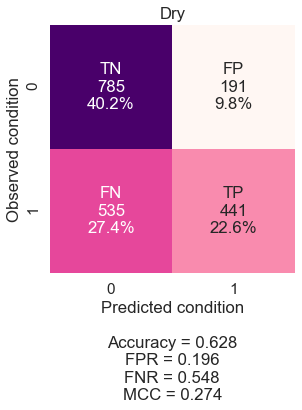

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 6))

low_lim = np.min(matrix)
upp_lim = np.max(matrix)

#Heatmap No Rain
group_names = ['TN', 'FP','FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=False, cmap='RdPu')

ax.set_title('Dry')
ax.set_ylabel('Observed condition')
ax.set_xlabel('Predicted condition' + stats)
plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\confusiontreebergueda.png', dpi=300)
plt.show()